# Image classification

In [50]:
import torch
from torch import Generator

# Set the random seed for reproducibility
random_state = 42

In [51]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


## Preprocessing

In [52]:
import os
from data import train_val_split

base_dir = './data/train'
train_dir = './data/preprocessed/train'
val_dir = './data/preprocessed/val'

val_ratio = 0.2

if not os.path.exists(train_dir) and not os.path.exists(val_dir):
    train_val_split(base_dir, train_dir, val_dir, val_ratio, random_state) 

    print("Saved train data to:", train_dir)
    print("Saved validation data to:", val_dir)
else:
    print("Train and validation directories already exist.")

Train and validation directories already exist.


## Data

### Augmentation

In [ ]:
import torchvision.transforms as transforms

mean_tensor = torch.tensor([0.5, 0.5, 0.5])
std_tensor = torch.tensor([0.5, 0.5, 0.5])

# mean_tensor = torch.tensor([0.5209, 0.4955, 0.4384])
# std_tensor = torch.tensor([0.2111, 0.2103, 0.2101])

default_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_tensor, std_tensor)
])

augmented_transform = transforms.Compose([
    transforms.RandomCrop(64, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean_tensor, std_tensor)
])

### Datasets and sampling

In [55]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, ConcatDataset
from data import sample_dataset

train_default_ds = ImageFolder(train_dir, transform=default_transform)
train_augmented_ds = ImageFolder(train_dir, transform=augmented_transform)
train_ds = ConcatDataset([train_default_ds, train_augmented_ds])

val_ds = ImageFolder(val_dir, transform=default_transform)

# downsample the dataset
sample_ratio = 0.25
sampled_train_ds = sample_dataset(train_ds, sample_ratio, seed=random_state)
sampled_val_ds = sample_dataset(val_ds, sample_ratio, seed=random_state)

num_classes = len(train_default_ds.classes)

print(f"Number of training samples: {len(sampled_train_ds)}")
print(f"Number of validation samples: {len(sampled_val_ds)}")

Number of training samples: 35204
Number of validation samples: 4400


In [56]:
# from plots import plot_class_distribution

# plot_class_distribution(sampled_train_ds)

### Data loaders

In [57]:
batch_size = 256
num_workers = 0

# setup data loaders
train_dl = DataLoader(sampled_train_ds,
                      batch_size=batch_size,
                      num_workers=num_workers,
                      shuffle=True,
                      generator=Generator().manual_seed(random_state))

val_dl = DataLoader(sampled_val_ds,
                    batch_size=batch_size,
                    num_workers=num_workers,
                    shuffle=False)

### Example

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7337755..1.8178412].


Sample image shape: torch.Size([3, 64, 64])
Sample label: 0


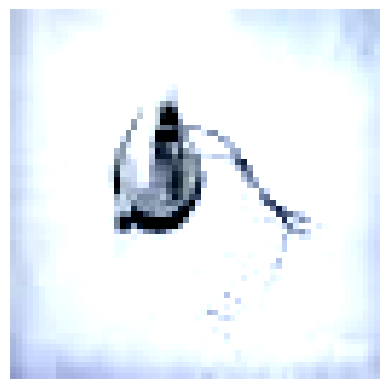

In [58]:
from utils import show_image

sample_img, sample_label = train_ds[0]

print(f"Sample image shape: {sample_img.size()}")
print(f"Sample label: {sample_label}")

show_image(sample_img)

## Training

In [59]:
from training import Trainer
import torch.optim as optim

### BasicModel

In [60]:
from models import BasicNet

basicNet = BasicNet(num_classes=num_classes)

optimizer = optim.Adam(basicNet.to(device).parameters(), lr=1e-4, weight_decay=1e-5)

trainer = Trainer(basicNet, train_dl, val_dl, optimizer, device=device)
trainer.train(num_epochs=10)

Epoch 1/10 (validation): 100%|██████████| 18/18 [00:03<00:00,  5.18it/s]


Epoch 1/10: Train Loss: 3.5728, Val Loss: 3.1749, Avg Class Accuracy: 0.1790


Epoch 2/10 (validation): 100%|██████████| 18/18 [00:03<00:00,  5.15it/s]


Epoch 2/10: Train Loss: 3.2220, Val Loss: 2.9003, Avg Class Accuracy: 0.2452


Epoch 3/10 (validation): 100%|██████████| 18/18 [00:03<00:00,  4.91it/s]


Epoch 3/10: Train Loss: 3.0278, Val Loss: 2.7302, Avg Class Accuracy: 0.2740


Epoch 4/10 (validation): 100%|██████████| 18/18 [00:03<00:00,  4.84it/s]


Epoch 4/10: Train Loss: 2.8790, Val Loss: 2.5942, Avg Class Accuracy: 0.3125


Epoch 5/10 (validation): 100%|██████████| 18/18 [00:03<00:00,  4.81it/s]


Epoch 5/10: Train Loss: 2.7587, Val Loss: 2.4964, Avg Class Accuracy: 0.3346


Epoch 6/10 (validation): 100%|██████████| 18/18 [00:03<00:00,  4.80it/s]


Epoch 6/10: Train Loss: 2.6572, Val Loss: 2.4243, Avg Class Accuracy: 0.3476


Epoch 7/10 (validation): 100%|██████████| 18/18 [00:03<00:00,  4.62it/s]


Epoch 7/10: Train Loss: 2.5870, Val Loss: 2.3684, Avg Class Accuracy: 0.3549


Epoch 8/10 (validation): 100%|██████████| 18/18 [00:03<00:00,  4.79it/s]


Epoch 8/10: Train Loss: 2.5270, Val Loss: 2.3198, Avg Class Accuracy: 0.3691


Epoch 9/10 (validation): 100%|██████████| 18/18 [00:03<00:00,  4.79it/s]


Epoch 9/10: Train Loss: 2.4702, Val Loss: 2.2692, Avg Class Accuracy: 0.3755


Epoch 10/10 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.22it/s]

Epoch 10/10: Train Loss: 2.4154, Val Loss: 2.2262, Avg Class Accuracy: 0.3863


### Renset-like model

In [8]:
# from models import SimpleResNet

# simpleResNet = SimpleResNet(num_classes=num_classes)

# optimizer = optim.Adam(simpleResNet.to(device).parameters(), lr=1e-3, weight_decay=1e-5)

# trainer = Trainer(simpleResNet, train_dl, val_dl, optimizer, device=device)
# trainer.train(num_epochs=10)

### Four-block CNN

In [9]:
from models import FourBlockCNN

fourBlockCNN = FourBlockCNN(num_classes=50)

optimizer = optim.Adam(fourBlockCNN.to(device).parameters(), lr=1e-4, weight_decay=1e-5)

trainer = Trainer(fourBlockCNN, train_dl, val_dl, optimizer, device=device)
trainer.train(num_epochs=20)

# Results:
# Without augmentation: Epoch 10/10: Train Loss: 2.2281, Val Loss: 2.4054, Avg Class Accuracy: 0.3387
# With augmentation: Epoch 10/10: Train Loss: 1.7477, Val Loss: 1.8611, Avg Class Accuracy: 0.4847

Epoch 1/20 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.10it/s]


Epoch 1/20: Train Loss: 3.3024, Val Loss: 3.5733, Avg Class Accuracy: 0.1213


Epoch 2/20 (validation): 100%|██████████| 69/69 [00:17<00:00,  3.92it/s]


Epoch 2/20: Train Loss: 2.7460, Val Loss: 3.4901, Avg Class Accuracy: 0.1737


Epoch 3/20 (validation): 100%|██████████| 69/69 [00:17<00:00,  3.91it/s]


Epoch 3/20: Train Loss: 2.4540, Val Loss: 2.9737, Avg Class Accuracy: 0.2378


Epoch 4/20 (validation): 100%|██████████| 69/69 [00:17<00:00,  3.85it/s]


Epoch 4/20: Train Loss: 2.2556, Val Loss: 2.8185, Avg Class Accuracy: 0.2789


Epoch 5/20 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.80it/s]


Epoch 5/20: Train Loss: 2.1076, Val Loss: 2.7340, Avg Class Accuracy: 0.2892


Epoch 6/20 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.78it/s]


Epoch 6/20: Train Loss: 1.9881, Val Loss: 2.6600, Avg Class Accuracy: 0.3135


Epoch 7/20 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.74it/s]


Epoch 7/20: Train Loss: 1.8871, Val Loss: 2.5154, Avg Class Accuracy: 0.3494


Epoch 8/20 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.78it/s]


Epoch 8/20: Train Loss: 1.7981, Val Loss: 2.3087, Avg Class Accuracy: 0.3861


Epoch 9/20 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.75it/s]


Epoch 9/20: Train Loss: 1.7298, Val Loss: 2.1465, Avg Class Accuracy: 0.4234


Epoch 10/20 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.74it/s]


Epoch 10/20: Train Loss: 1.6585, Val Loss: 2.0331, Avg Class Accuracy: 0.4497


Epoch 11/20 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.62it/s]


Epoch 11/20: Train Loss: 1.5961, Val Loss: 1.9840, Avg Class Accuracy: 0.4616


Epoch 12/20 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.69it/s]


Epoch 12/20: Train Loss: 1.5370, Val Loss: 1.9631, Avg Class Accuracy: 0.4698


Epoch 13/20 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.66it/s]


Epoch 13/20: Train Loss: 1.4848, Val Loss: 1.8858, Avg Class Accuracy: 0.4844


Epoch 14/20 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.57it/s]


Epoch 14/20: Train Loss: 1.4421, Val Loss: 1.8203, Avg Class Accuracy: 0.5091


Epoch 15/20 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.67it/s]


Epoch 15/20: Train Loss: 1.3988, Val Loss: 1.8170, Avg Class Accuracy: 0.5063


Epoch 16/20 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.65it/s]


Epoch 16/20: Train Loss: 1.3530, Val Loss: 1.7241, Avg Class Accuracy: 0.5261


Epoch 17/20 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.65it/s]


Epoch 17/20: Train Loss: 1.3146, Val Loss: 1.7582, Avg Class Accuracy: 0.5270


Epoch 18/20 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.65it/s]


Epoch 18/20: Train Loss: 1.2846, Val Loss: 1.6729, Avg Class Accuracy: 0.5446


Epoch 19/20 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.62it/s]


Epoch 19/20: Train Loss: 1.2455, Val Loss: 1.5932, Avg Class Accuracy: 0.5629


Epoch 20/20 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.66it/s]

Epoch 20/20: Train Loss: 1.2140, Val Loss: 1.6710, Avg Class Accuracy: 0.5481


## Resnet18

Here we train the ResNet18 model on the dataset to see the state of the art performance.

In [10]:
import torch.nn as nn

resnet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

in_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(in_features, num_classes)

resnet18 = resnet18.to(device)

optimizer = optim.Adam(resnet18.parameters(), lr=1e-4, weight_decay=1e-5)

trainer = Trainer(resnet18, train_dl, val_dl, optimizer, device=device)
trainer.train(num_epochs=20)

Using cache found in /Users/grzegorzstatkiewicz/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/grzegorzstatkiewicz/Documents/studies/ssne/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/grzegorzstatkiewicz/Documents/studies/ssne/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch 1/20 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.50it/s]


Epoch 1/20: Train Loss: 2.7824, Val Loss: 2.4378, Avg Class Accuracy: 0.3320


Epoch 2/20 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.38it/s]


Epoch 2/20: Train Loss: 2.1387, Val Loss: 2.1194, Avg Class Accuracy: 0.4181


Epoch 3/20 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.34it/s]


Epoch 3/20: Train Loss: 1.8145, Val Loss: 2.0159, Avg Class Accuracy: 0.4526


Epoch 4/20 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.37it/s]


Epoch 4/20: Train Loss: 1.5512, Val Loss: 1.9710, Avg Class Accuracy: 0.4640


Epoch 5/20 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.31it/s]


Epoch 5/20: Train Loss: 1.3172, Val Loss: 1.9486, Avg Class Accuracy: 0.4789


Epoch 6/20 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.32it/s]


Epoch 6/20: Train Loss: 1.1019, Val Loss: 1.9828, Avg Class Accuracy: 0.4856


Epoch 7/20 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.31it/s]


Epoch 7/20: Train Loss: 0.9306, Val Loss: 2.0348, Avg Class Accuracy: 0.4912


Epoch 8/20 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.45it/s]


Epoch 8/20: Train Loss: 0.7978, Val Loss: 2.1219, Avg Class Accuracy: 0.4962


Epoch 9/20 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.42it/s]


Epoch 9/20: Train Loss: 0.7041, Val Loss: 2.1299, Avg Class Accuracy: 0.4963


Epoch 10/20 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.39it/s]


Epoch 10/20: Train Loss: 0.6226, Val Loss: 2.1874, Avg Class Accuracy: 0.4970


Epoch 11/20 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.38it/s]


Epoch 11/20: Train Loss: 0.5756, Val Loss: 2.2226, Avg Class Accuracy: 0.4987


Epoch 12/20 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.39it/s]


Epoch 12/20: Train Loss: 0.5304, Val Loss: 2.2860, Avg Class Accuracy: 0.4952


Epoch 13/20 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.41it/s]


Epoch 13/20: Train Loss: 0.4914, Val Loss: 2.2734, Avg Class Accuracy: 0.5028


Epoch 14/20 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.41it/s]


Epoch 14/20: Train Loss: 0.4575, Val Loss: 2.2841, Avg Class Accuracy: 0.5050


Epoch 15/20 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.35it/s]


Epoch 15/20: Train Loss: 0.4213, Val Loss: 2.3178, Avg Class Accuracy: 0.5096


Epoch 16/20 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.40it/s]


Epoch 16/20: Train Loss: 0.3918, Val Loss: 2.3276, Avg Class Accuracy: 0.5065


Epoch 17/20 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.37it/s]


Epoch 17/20: Train Loss: 0.3736, Val Loss: 2.3495, Avg Class Accuracy: 0.5092


Epoch 18/20 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.40it/s]


Epoch 18/20: Train Loss: 0.3491, Val Loss: 2.4328, Avg Class Accuracy: 0.5094


Epoch 19/20 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.39it/s]


Epoch 19/20: Train Loss: 0.3224, Val Loss: 2.4313, Avg Class Accuracy: 0.5070


Epoch 20/20 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.38it/s]

Epoch 20/20: Train Loss: 0.3031, Val Loss: 2.4299, Avg Class Accuracy: 0.5105


## Save models

In [11]:
torch.save(basicNet.state_dict(), "./models/basicNet.pth")

In [12]:
torch.save(fourBlockCNN.state_dict(), "./models/fourBlockCNN.pth")

In [13]:
torch.save(resnet18.state_dict(), "./models/resnet18.pth")